In [1]:
using Clustering, PyPlot
using TextAnalysis
using JLD2
using Statistics
using XLSX
using CSV
using DataFrames
using Dates
using LinearAlgebra
using StatsBase
using MultivariateStats
using Random

In [2]:
include("../src/utill.jl")

make_plots (generic function with 1 method)

In [3]:
new_df = XLSX.readxlsx("../data/Data-Spring/covid-ru.xlsx")["Sheet1"]
stop_ind = new_df.dimension.stop;

en_1 = DataFrame(new_df["A2:$stop_ind"],  [:retweet_count, :favorite_count, 
        :created_at, :text, :id_str, 
        :lang])
mask_tmp = ones(Bool, length(en_1.id_str)) 
insert!(en_1, 7, mask_tmp, :tind)


new_df = XLSX.readxlsx("../data/Data-Winter/covid-ru.xlsx")["Sheet1"]
stop_ind = new_df.dimension.stop;

en_2 = DataFrame(new_df["A2:$stop_ind"],  [:retweet_count, :favorite_count, 
        :created_at, :text, :id_str, 
        :lang]);

mask_tmp = zeros(Bool, length(en_2.id_str)) 
insert!(en_2, 7, mask_tmp, :tind)

min_dim = minimum([length(en_1.tind), length(en_2.tind)])

df = append!(en_1[1:min_dim, :], en_2[1:min_dim, :]);

df = df[shuffle(1:length(df.favorite_count)), :]

,retweet_count,favorite_count,created_at,text
,Any,Any,Any,Any
1,0,0,2020-12-15T14:43:16,Очень необычная инициатива.\nhttps://t.co/k0bQEdzkHk
2,0,0,2020-12-14T08:29:22,"С 7 по 13 декабря в Тульской области – 1433 новых случаев коронавируса, выздоровели 1155 человек, умерли 50. Всего инфицированных – 19313, из них: выздоровели 16915, умерли 567, болеют прямо сейчас 1831.\n#здоровье #вирус #коронавирус #covid19 #инфекция https://t.co/AHP4JSGaxB"
3,0,0,2020-12-16T08:01:56,Китай соблюдает свои обязательства по вакцине от COVID-19\n\nhttps://t.co/L2ko6lAaX4
4,0,0,2020-12-11T11:56:06,"Почему не всех нижегородцев забирают с COVID-19 и как это влияет на выплаты. Рассказ водителя скорой\n\nМедик признает, что пандемия сильно загрузила систему здравоохранения\nhttps://t.co/psZvxfUieg https://t.co/qAsHW5HKoe"
5,0,0,2020-04-13T16:00:02,@kloopnews Опасность заражения высокая. Медики были против. Но сегодня был Кочкоров. По ходу уже решено быть здесь больным от covid-19. Но со слов медиков это вирусная бомба в центре города.
6,0,1,2020-04-12T19:51:12,"на территории Украины острой респираторной болезни COVID-19, вызванной коронавирусом SARS-CoV-2», сообщает «УНИАН». \nВ судебном заседании мужчина пояснил, что не имел возможности купить в селе защитную маску или изготовить ее, поэтому находился на остановке общественного"
7,0,0,2020-12-11T15:59:27,В Москве для новых групп риска откроют запись на вакцинацию от COVID-19 https://t.co/yC02ptVA7H https://t.co/McsT4ZjGA0
8,0,1,2020-12-15T09:50:09,😷Во многих странах мира вводится жесткий локдаун\n\nhttps://t.co/8tK55vFZaA\n\n#коронавирус #COVID19 #koronavirus #вакцина #пандемия #дезинфекция #вирус #Баку #Азербайджан #TƏBİB #карантин #cbcaz
9,1,0,2020-12-10T19:04:31,Украинцы могут спокойно нести шлейф Covid-19 в массы — государство не способно это остановить • ... https://t.co/pBlnJQ69MC


## Preprocessing:

In [18]:
function preprocess_corp(data)
    data_preprocessed = replace.(data, r"http\S+" => s"")
    data_preprocessed = replace.(data_preprocessed, r"\S+.com" => s"")
    data_preprocessed = replace.(data_preprocessed, r"resulting" => s"")
    data_preprocessed = replace.(data_preprocessed, r"RESULTING" => s"")
    data_preprocessed = replace.(data_preprocessed, r"#resulting" => s"")
    data_preprocessed = replace.(data_preprocessed, r"@\S+" => s"")
    data_preprocessed = replace.(data_preprocessed, r"&amp" => s"")
    data_preprocessed = replace.(data_preprocessed, r"RT\S+" => s"");

    crps_tmp = Corpus(StringDocument.(deepcopy(data_preprocessed)));

    remove_case!(crps_tmp)
    prepare!(crps_tmp, strip_punctuation)
    prepare!(crps_tmp, strip_numbers)
    prepare!(crps_tmp, strip_articles)

#     prepare!(crps_tmp, strip_stopwords)
#     remove_words!(crps_tmp, ["covid", "коронавирус", "коронавируса", "коронавирусом", "новых", "случаев", "сутки", "coronavirus", 
#             "области", "число", "человек", "россии", "пациентов", "новости", "более", "после", "всего", "против", "апреля", "может", "тысяч", "будет", "пандемии", "декабря", "коронавирусной",  "подробнее", "украине",
#             "выявили", "выявлено", "которые", "только", "случая", "через", "случаи", "будут", "последние", "время", "сегодня", "больше", "борьбе"])
    stem!(crps_tmp)
    prepare!(crps_tmp, strip_whitespace)
    update_lexicon!(crps_tmp)
    return crps_tmp
end

preprocess_corp (generic function with 1 method)

In [19]:
crps = preprocess_corp(df[:,4])

A Corpus with 25744 documents:
 * 25744 StringDocument's
 * 0 FileDocument's
 * 0 TokenDocument's
 * 0 NGramDocument's

Corpus's lexicon contains 48116 tokens
Corpus's index contains 0 tokens

In [20]:
# TextAnalysis.text(crps[100])

In [21]:
# crps_1 = preprocess_corp(df[df.tind,4])
# crps_2 = preprocess_corp(df[.!df.tind,4]);

In [42]:
# Create a vector from merged corpus: 

lexicone_vect = lexicon(crps)

n_max = 201
pairs = sort(collect(lexicone_vect), by=x->x[2], rev=true)[1:n_max]
terms = [i[1] for i in pairs]

terms_mask = [length(term)>4 for term in terms]
terms = terms[terms_mask];

In [43]:
terms

120-element Array{String,1}:
 "covid"
 "коронавирус"
 "случаев"
 "сутки"
 "человек"
 "россии"
 "области"
 "коронавируса"
 "новых"
 "коронавирусом"
 "число"
 "coronavirus"
 "пациентов"
 ⋮
 "инфицированных"
 "также"
 "инфекцией"
 "среди"
 "сообщает"
 "статистика"
 "медиков"
 "помощи"
 "связи"
 "видео"
 "заразились"
 "регионах"

In [44]:
terms #[1:25]

120-element Array{String,1}:
 "covid"
 "коронавирус"
 "случаев"
 "сутки"
 "человек"
 "россии"
 "области"
 "коронавируса"
 "новых"
 "коронавирусом"
 "число"
 "coronavirus"
 "пациентов"
 ⋮
 "инфицированных"
 "также"
 "инфекцией"
 "среди"
 "сообщает"
 "статистика"
 "медиков"
 "помощи"
 "связи"
 "видео"
 "заразились"
 "регионах"

In [45]:
m = DocumentTermMatrix(crps, terms)

A 25744 X 120 DocumentTermMatrix

In [46]:
D = convert.(Float64, dtm(m, :dense)')

# D[:,df.tind] = D[:,df.tind] ./ sum(D[:,df.tind])
# D[:,.!df.tind] = D[:,.!df.tind] ./ sum(D[:,.!df.tind]);

In [47]:
# PCA:

M = fit(PCA, D; maxoutdim=120)
Yte = MultivariateStats.transform(M, D)

116×25744 Array{Float64,2}:
  0.417452     -1.60097     0.193935     …   0.0523553   0.181801
  0.751747      0.580262   -0.157042        -0.118402   -0.160842
 -0.344894      0.821001   -0.085919         0.0518136  -0.0728946
 -0.17799       0.35859    -0.0216328       -0.205573   -0.0296989
 -0.00488291   -0.76515    -0.00911686      -0.0193517  -0.00478454
  0.0687815    -0.814154    0.00350958   …  -0.207743    0.00930733
  0.0587502    -1.04322     0.0632157        0.0123813   0.0715833
 -0.00822019    0.156294   -0.0248256        0.312456   -0.0435714
  0.0835458     0.331723    0.00239772      -0.219951    0.117331
 -0.0637864    -0.48739    -0.0517476        0.271508    0.0372304
  0.0697102    -0.595998    0.0344851    …   0.499332    0.0282938
  0.0523374     0.441252    0.0186544        0.139543    0.012824
  0.0170619     0.0030447  -0.0379563       -0.237019   -0.0511812
  ⋮                                      ⋱              
 -0.00318682   -0.0350599  -0.0103084        0

# NN: 

In [48]:
include("../src/nn.jl")

params_importance (generic function with 1 method)

In [49]:
y = onehotbatch(df.tind, 0:1)
x = D .- mean(D, dims=2) ; x = x ./ std(x, dims=2);

# x = Yte;

In [50]:
result = train(x, y)

model_tmp = result.model
trdata = result.trdata
tstdata = result.tstdata;

┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69215024
│   loss_test = 0.6918306
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6486453
│   loss_test = 0.64872247
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6256054
│   loss_test = 0.6260463
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6154031
│   loss_test = 0.6155533
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6101143
│   loss_test = 0.61107

  9.849503 seconds (119.80 M allocations: 4.311 GiB, 9.78% gc time)


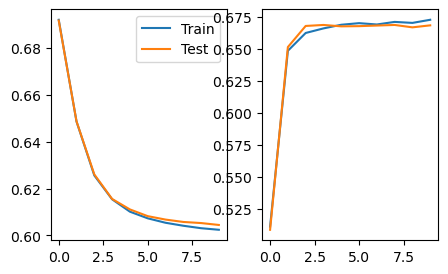

PyObject <matplotlib.legend.Legend object at 0x7fb66e1173d0>

In [51]:
fig, ax = plt.subplots(1,2, figsize=(5,3))

loss_vect = result.loss
acc_vector = result.acc

ax[1].plot(loss_vect[1], label="Train")
ax[1].plot(loss_vect[2], label="Test")
ax[2].plot(acc_vector[1])
ax[2].plot(acc_vector[2])
ax[1].legend()

In [52]:
roc_tr = roc_curve(trdata..., model_tmp)
roc_test = roc_curve(tstdata..., model_tmp);

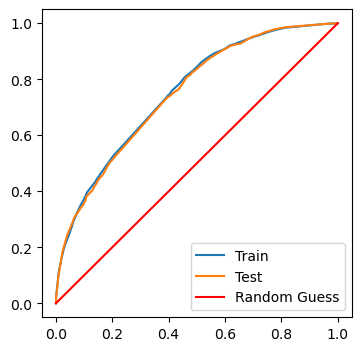

PyObject <matplotlib.legend.Legend object at 0x7fb66e24b6a0>

In [53]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.plot(roc_tr.fpr, roc_tr.tpr,  label="Train")
ax.plot(roc_test.fpr, roc_test.tpr, label="Test")
ax.plot(0:1, 0:1, color="red", label="Random Guess")
ax.legend()

In [54]:
@show roc_tr.auc, roc_test.auc

(roc_tr.auc, roc_test.auc) = (0.7522887345648595, 0.7483724898565798)


(0.7522887345648595, 0.7483724898565798)

In [55]:
test_int = 1:120
par_importance = params_importance(x, y, test_int)

i = 1


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69929564
│   loss_test = 0.6942465
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65159154
│   loss_test = 0.6553003
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62900954
│   loss_test = 0.63331306
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6175233
│   loss_test = 0.6232838
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6117571
│   loss_test = 0.617

  9.926210 seconds (119.41 M allocations: 4.293 GiB, 6.50% gc time)
i = 2


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6959859
│   loss_test = 0.6957449
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65090704
│   loss_test = 0.65477395
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6274752
│   loss_test = 0.63333863
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61575556
│   loss_test = 0.62195086
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.60999304
│   loss_test = 0.6

  9.492168 seconds (119.41 M allocations: 4.293 GiB, 6.52% gc time)
i = 3


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69466835
│   loss_test = 0.69422424
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.651866
│   loss_test = 0.6511317
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6298551
│   loss_test = 0.62862587
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6181924
│   loss_test = 0.617133
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6118389
│   loss_test = 0.611294

  9.610785 seconds (119.41 M allocations: 4.293 GiB, 6.72% gc time)
i = 4


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.70146763
│   loss_test = 0.7037428
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6528982
│   loss_test = 0.6551726
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.63161504
│   loss_test = 0.63467157
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62054193
│   loss_test = 0.6240777
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6149109
│   loss_test = 0.618

  9.646269 seconds (119.41 M allocations: 4.293 GiB, 6.55% gc time)
i = 5


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.695431
│   loss_test = 0.69588697
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6474151
│   loss_test = 0.65012294
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6249843
│   loss_test = 0.6292429
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61464757
│   loss_test = 0.61928254
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.60935265
│   loss_test = 0.614

  9.767630 seconds (119.41 M allocations: 4.293 GiB, 7.01% gc time)
i = 6


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7015405
│   loss_test = 0.70187944
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6531241
│   loss_test = 0.653557
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6295303
│   loss_test = 0.63063836
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6175224
│   loss_test = 0.6185581
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.611475
│   loss_test = 0.6134845

  9.698556 seconds (119.41 M allocations: 4.293 GiB, 6.99% gc time)
i = 7


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69263667
│   loss_test = 0.6926767
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6527605
│   loss_test = 0.6546127
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6271872
│   loss_test = 0.6308238
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6151848
│   loss_test = 0.62039506
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.60921913
│   loss_test = 0.6158

 10.108174 seconds (119.41 M allocations: 4.293 GiB, 12.01% gc time)
i = 8


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7035111
│   loss_test = 0.7041666
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6522296
│   loss_test = 0.65565217
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62836194
│   loss_test = 0.63369805
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61587447
│   loss_test = 0.6224021
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.60988545
│   loss_test = 0.61

  9.636744 seconds (119.41 M allocations: 4.293 GiB, 6.48% gc time)
i = 9


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.691048
│   loss_test = 0.6907658
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.64924604
│   loss_test = 0.64975166
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6264894
│   loss_test = 0.6274077
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61547303
│   loss_test = 0.61712515
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61019343
│   loss_test = 0.612

  9.495288 seconds (119.41 M allocations: 4.293 GiB, 6.83% gc time)
i = 10


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69567645
│   loss_test = 0.6979922
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65188
│   loss_test = 0.6509627
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6288296
│   loss_test = 0.6269914
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61759484
│   loss_test = 0.6158439
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6116336
│   loss_test = 0.6110852

  9.576998 seconds (119.41 M allocations: 4.293 GiB, 6.58% gc time)
i = 11


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6922673
│   loss_test = 0.6922711
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6498167
│   loss_test = 0.65075856
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62639356
│   loss_test = 0.6275553
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.615294
│   loss_test = 0.61652666
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61009574
│   loss_test = 0.6115

  9.440179 seconds (119.41 M allocations: 4.293 GiB, 6.94% gc time)
i = 12


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69823515
│   loss_test = 0.69906247
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65759975
│   loss_test = 0.65843135
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6335429
│   loss_test = 0.635287
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62264
│   loss_test = 0.6252232
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6170369
│   loss_test = 0.619999

  9.537411 seconds (119.41 M allocations: 4.293 GiB, 6.98% gc time)
i = 13


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69169235
│   loss_test = 0.6926267
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6484757
│   loss_test = 0.64856356
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.625797
│   loss_test = 0.6257986
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61624753
│   loss_test = 0.61555815
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61062235
│   loss_test = 0.610

  9.409378 seconds (119.41 M allocations: 4.293 GiB, 7.11% gc time)
i = 14


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7008788
│   loss_test = 0.69886917
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6497642
│   loss_test = 0.65151876
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6260672
│   loss_test = 0.6293033
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.615052
│   loss_test = 0.61957103
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6095575
│   loss_test = 0.61511

  9.478478 seconds (119.41 M allocations: 4.293 GiB, 7.01% gc time)
i = 15


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6977813
│   loss_test = 0.69765484
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6527554
│   loss_test = 0.656502
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.63181984
│   loss_test = 0.63679886
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6215302
│   loss_test = 0.6272014
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6166467
│   loss_test = 0.62267

  9.961740 seconds (119.41 M allocations: 4.293 GiB, 12.33% gc time)
i = 16


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69513655
│   loss_test = 0.69522554
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65244913
│   loss_test = 0.6530857
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6284615
│   loss_test = 0.628779
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6175899
│   loss_test = 0.61787546
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6121308
│   loss_test = 0.6122

  9.287119 seconds (119.41 M allocations: 4.293 GiB, 6.60% gc time)
i = 17


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6952131
│   loss_test = 0.6959136
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.652064
│   loss_test = 0.6576108
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62688017
│   loss_test = 0.6353129
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61474246
│   loss_test = 0.62430614
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6089496
│   loss_test = 0.61919

  9.423668 seconds (119.41 M allocations: 4.293 GiB, 6.81% gc time)
i = 18


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69409674
│   loss_test = 0.69279677
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.64937985
│   loss_test = 0.6530912
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62567145
│   loss_test = 0.63270843
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6142528
│   loss_test = 0.6226206
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6087465
│   loss_test = 0.61

  9.267033 seconds (119.41 M allocations: 4.293 GiB, 6.64% gc time)
i = 19


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.70233065
│   loss_test = 0.70249635
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65105844
│   loss_test = 0.6522471
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62877846
│   loss_test = 0.6319161
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6172948
│   loss_test = 0.62135816
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61163586
│   loss_test = 0.6

  9.360477 seconds (119.41 M allocations: 4.293 GiB, 6.98% gc time)
i = 20


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7018166
│   loss_test = 0.7030183
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.654339
│   loss_test = 0.6533938
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6344917
│   loss_test = 0.6327765
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62486494
│   loss_test = 0.6226632
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61982536
│   loss_test = 0.617864

  9.362735 seconds (119.41 M allocations: 4.293 GiB, 7.01% gc time)
i = 21


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69426405
│   loss_test = 0.69438523
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6474764
│   loss_test = 0.6509881
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6259715
│   loss_test = 0.6312822
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61518204
│   loss_test = 0.62176144
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.60962933
│   loss_test = 0.61

  9.345985 seconds (119.41 M allocations: 4.293 GiB, 6.94% gc time)
i = 22


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.71303576
│   loss_test = 0.7157687
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6509255
│   loss_test = 0.65657943
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62744385
│   loss_test = 0.63574255
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61596763
│   loss_test = 0.6254478
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6103865
│   loss_test = 0.62

  9.362893 seconds (119.41 M allocations: 4.293 GiB, 6.86% gc time)
i = 23


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69733495
│   loss_test = 0.6983753
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.64843976
│   loss_test = 0.65268886
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62460905
│   loss_test = 0.63255817
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6132762
│   loss_test = 0.62406623
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6075993
│   loss_test = 0.6

  9.874717 seconds (119.41 M allocations: 4.293 GiB, 12.25% gc time)
i = 24


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69476396
│   loss_test = 0.6956215
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6498526
│   loss_test = 0.6540619
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6241825
│   loss_test = 0.63187546
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61312586
│   loss_test = 0.6226193
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6080545
│   loss_test = 0.6186

  9.301105 seconds (119.41 M allocations: 4.293 GiB, 6.55% gc time)
i = 25


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69398427
│   loss_test = 0.69473803
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6522402
│   loss_test = 0.6587685
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6304574
│   loss_test = 0.6380392
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6200961
│   loss_test = 0.628187
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61421007
│   loss_test = 0.62219

  9.815462 seconds (119.41 M allocations: 4.293 GiB, 9.07% gc time)
i = 26


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6884004
│   loss_test = 0.6887486
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.64799976
│   loss_test = 0.6476077
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62738395
│   loss_test = 0.62696123
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61718893
│   loss_test = 0.6164874
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6123872
│   loss_test = 0.611

  9.281479 seconds (119.41 M allocations: 4.293 GiB, 6.34% gc time)
i = 27


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7027413
│   loss_test = 0.7038668
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6514414
│   loss_test = 0.65500987
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62743837
│   loss_test = 0.6332904
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61550295
│   loss_test = 0.6226667
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6093735
│   loss_test = 0.6173

  9.323627 seconds (119.41 M allocations: 4.293 GiB, 6.70% gc time)
i = 28


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69726837
│   loss_test = 0.697651
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65336984
│   loss_test = 0.6547541
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62764645
│   loss_test = 0.6292363
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61591446
│   loss_test = 0.6181939
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6102195
│   loss_test = 0.6141

  9.467813 seconds (119.41 M allocations: 4.293 GiB, 6.56% gc time)
i = 29


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7000573
│   loss_test = 0.70090723
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6526788
│   loss_test = 0.6535952
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6291557
│   loss_test = 0.630554
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6173068
│   loss_test = 0.61919665
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6111308
│   loss_test = 0.613512

  9.566660 seconds (119.41 M allocations: 4.293 GiB, 6.69% gc time)
i = 30


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7007101
│   loss_test = 0.70328206
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6484374
│   loss_test = 0.65171397
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6264288
│   loss_test = 0.6312007
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6155178
│   loss_test = 0.6212335
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.609946
│   loss_test = 0.616156

  9.354164 seconds (119.41 M allocations: 4.293 GiB, 7.00% gc time)
i = 31


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69469786
│   loss_test = 0.69442517
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65055555
│   loss_test = 0.6509707
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6272746
│   loss_test = 0.62787896
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61640924
│   loss_test = 0.6170067
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6110351
│   loss_test = 0.61

  9.399027 seconds (119.41 M allocations: 4.293 GiB, 7.01% gc time)
i = 32


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69284743
│   loss_test = 0.69229466
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.64848393
│   loss_test = 0.65014756
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62512106
│   loss_test = 0.62807095
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6143285
│   loss_test = 0.6181646
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.60931987
│   loss_test = 0.

  9.538973 seconds (119.41 M allocations: 4.293 GiB, 9.83% gc time)
i = 33


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6927028
│   loss_test = 0.6922894
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.650496
│   loss_test = 0.6505798
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6270551
│   loss_test = 0.6270237
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61589
│   loss_test = 0.6167743
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6104536
│   loss_test = 0.6123892
└ 

  9.268897 seconds (119.41 M allocations: 4.293 GiB, 6.32% gc time)
i = 34


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69900984
│   loss_test = 0.69702727
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65318847
│   loss_test = 0.6558285
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62831914
│   loss_test = 0.6328134
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6162393
│   loss_test = 0.62194914
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6098878
│   loss_test = 0.61

  9.341688 seconds (119.41 M allocations: 4.293 GiB, 6.72% gc time)
i = 35


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69505525
│   loss_test = 0.6951887
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.64989614
│   loss_test = 0.6525652
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6257646
│   loss_test = 0.6295697
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61410123
│   loss_test = 0.6198051
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6088882
│   loss_test = 0.6157

  9.289490 seconds (119.41 M allocations: 4.293 GiB, 6.73% gc time)
i = 36


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69406164
│   loss_test = 0.69415176
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6501884
│   loss_test = 0.65285325
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62659335
│   loss_test = 0.6305916
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6154004
│   loss_test = 0.6201341
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.60957587
│   loss_test = 0.61

  9.310380 seconds (119.41 M allocations: 4.293 GiB, 6.86% gc time)
i = 37


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6909958
│   loss_test = 0.690489
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6494849
│   loss_test = 0.64782554
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62639624
│   loss_test = 0.62399364
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61552715
│   loss_test = 0.6133483
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6108448
│   loss_test = 0.6087

  9.477178 seconds (119.41 M allocations: 4.293 GiB, 7.06% gc time)
i = 38


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6971542
│   loss_test = 0.6965332
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65202016
│   loss_test = 0.6538708
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6280614
│   loss_test = 0.63123494
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6166894
│   loss_test = 0.620452
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61103964
│   loss_test = 0.61593

  9.349053 seconds (119.41 M allocations: 4.293 GiB, 7.06% gc time)
i = 39


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69545424
│   loss_test = 0.6963133
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6483406
│   loss_test = 0.6515902
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62451094
│   loss_test = 0.63021624
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6137116
│   loss_test = 0.6204068
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.60847956
│   loss_test = 0.615

  9.396423 seconds (119.41 M allocations: 4.293 GiB, 6.93% gc time)
i = 40


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69597256
│   loss_test = 0.69356984
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.64881814
│   loss_test = 0.6518224
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6255356
│   loss_test = 0.6289361
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61535263
│   loss_test = 0.6195199
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6096997
│   loss_test = 0.614

  9.793440 seconds (119.41 M allocations: 4.293 GiB, 12.19% gc time)
i = 41


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6914786
│   loss_test = 0.6911847
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.64865077
│   loss_test = 0.6490649
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62540734
│   loss_test = 0.62694526
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61521477
│   loss_test = 0.6176034
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6099349
│   loss_test = 0.613

  9.362905 seconds (119.41 M allocations: 4.293 GiB, 6.59% gc time)
i = 42


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69740105
│   loss_test = 0.6965232
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6483119
│   loss_test = 0.64999366
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6247893
│   loss_test = 0.62712693
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.614755
│   loss_test = 0.61726373
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6098573
│   loss_test = 0.6124

  9.346628 seconds (119.41 M allocations: 4.293 GiB, 6.57% gc time)
i = 43


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6894521
│   loss_test = 0.68968725
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6475623
│   loss_test = 0.65162665
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62493706
│   loss_test = 0.6301637
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61441934
│   loss_test = 0.62085456
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.608909
│   loss_test = 0.615

  9.293063 seconds (119.41 M allocations: 4.293 GiB, 6.58% gc time)
i = 44


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7051833
│   loss_test = 0.705802
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.648754
│   loss_test = 0.65380436
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6260389
│   loss_test = 0.6341352
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6149229
│   loss_test = 0.62522864
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6083701
│   loss_test = 0.6200459

  9.573677 seconds (119.41 M allocations: 4.293 GiB, 6.92% gc time)
i = 45


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6921496
│   loss_test = 0.6911593
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6476404
│   loss_test = 0.6504396
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62546474
│   loss_test = 0.6303647
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6148098
│   loss_test = 0.62148863
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6089762
│   loss_test = 0.61677

 10.628169 seconds (119.41 M allocations: 4.293 GiB, 6.79% gc time)
i = 46


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.706121
│   loss_test = 0.7081939
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6542486
│   loss_test = 0.6562394
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6295338
│   loss_test = 0.6327725
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.616722
│   loss_test = 0.62181425
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6102947
│   loss_test = 0.6163855


  9.451685 seconds (119.41 M allocations: 4.293 GiB, 7.01% gc time)
i = 47


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7001501
│   loss_test = 0.70380914
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6507351
│   loss_test = 0.65384245
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6280501
│   loss_test = 0.6317159
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.616587
│   loss_test = 0.62168384
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6107672
│   loss_test = 0.61583

  9.592836 seconds (119.41 M allocations: 4.293 GiB, 7.04% gc time)
i = 48


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7034915
│   loss_test = 0.7061991
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6527427
│   loss_test = 0.6545412
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6288573
│   loss_test = 0.6323571
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61742544
│   loss_test = 0.6218507
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61103225
│   loss_test = 0.61629

  9.791372 seconds (119.41 M allocations: 4.293 GiB, 12.06% gc time)
i = 49


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.70334256
│   loss_test = 0.7035796
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6529967
│   loss_test = 0.6540864
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.628133
│   loss_test = 0.63002217
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61603445
│   loss_test = 0.6188095
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6100291
│   loss_test = 0.61366

  9.272139 seconds (119.41 M allocations: 4.293 GiB, 6.51% gc time)
i = 50


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69342715
│   loss_test = 0.69432473
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6478021
│   loss_test = 0.652404
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62532866
│   loss_test = 0.63178897
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61441654
│   loss_test = 0.62211645
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6091039
│   loss_test = 0.61

  9.238639 seconds (119.41 M allocations: 4.293 GiB, 6.48% gc time)
i = 51


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6923939
│   loss_test = 0.69285744
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65137434
│   loss_test = 0.652067
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62863433
│   loss_test = 0.630087
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61793715
│   loss_test = 0.6196935
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61248153
│   loss_test = 0.6147

  9.215794 seconds (119.41 M allocations: 4.293 GiB, 6.49% gc time)
i = 52


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7382788
│   loss_test = 0.73838156
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6502565
│   loss_test = 0.6545475
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62794656
│   loss_test = 0.63411754
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61685836
│   loss_test = 0.6243179
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61108416
│   loss_test = 0.61

  9.355680 seconds (119.41 M allocations: 4.293 GiB, 6.85% gc time)
i = 53


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69461143
│   loss_test = 0.6951595
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.652778
│   loss_test = 0.65386456
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.63049316
│   loss_test = 0.6313258
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6199459
│   loss_test = 0.62047267
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61486506
│   loss_test = 0.615

  9.417678 seconds (119.41 M allocations: 4.293 GiB, 7.00% gc time)
i = 54


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69744045
│   loss_test = 0.6986727
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6513779
│   loss_test = 0.65524423
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62706167
│   loss_test = 0.6324346
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6155306
│   loss_test = 0.6214383
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6103453
│   loss_test = 0.6172

  9.357561 seconds (119.41 M allocations: 4.293 GiB, 7.02% gc time)
i = 55


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6967604
│   loss_test = 0.69646204
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6525738
│   loss_test = 0.65476286
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6275501
│   loss_test = 0.63078934
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.615807
│   loss_test = 0.6195827
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61013234
│   loss_test = 0.6152

  9.295502 seconds (119.41 M allocations: 4.293 GiB, 7.01% gc time)
i = 56


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.72245264
│   loss_test = 0.7286716
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6511477
│   loss_test = 0.65478235
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6281379
│   loss_test = 0.6328745
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6164932
│   loss_test = 0.62258244
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6106714
│   loss_test = 0.6175

  9.736299 seconds (119.41 M allocations: 4.293 GiB, 12.32% gc time)
i = 57


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6908575
│   loss_test = 0.69136953
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.64680684
│   loss_test = 0.64782435
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62534684
│   loss_test = 0.62686145
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6154456
│   loss_test = 0.617338
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61018765
│   loss_test = 0.61

  9.289460 seconds (119.41 M allocations: 4.293 GiB, 6.49% gc time)
i = 58


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.71215075
│   loss_test = 0.7098202
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6533188
│   loss_test = 0.6548397
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62973315
│   loss_test = 0.63286835
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6182157
│   loss_test = 0.62225574
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6120077
│   loss_test = 0.616

  9.282942 seconds (119.41 M allocations: 4.293 GiB, 6.64% gc time)
i = 59


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69292104
│   loss_test = 0.6931298
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.64931864
│   loss_test = 0.65056044
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62580764
│   loss_test = 0.6272385
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6153638
│   loss_test = 0.61737245
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6102639
│   loss_test = 0.61

  9.399508 seconds (119.41 M allocations: 4.293 GiB, 6.63% gc time)
i = 60


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7004214
│   loss_test = 0.7033831
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6545201
│   loss_test = 0.65555763
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6301346
│   loss_test = 0.63210034
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61785525
│   loss_test = 0.6189474
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6113436
│   loss_test = 0.6133

  9.324165 seconds (119.41 M allocations: 4.293 GiB, 6.88% gc time)
i = 61


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6903383
│   loss_test = 0.6903199
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6475626
│   loss_test = 0.65108144
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6253901
│   loss_test = 0.6314891
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6156203
│   loss_test = 0.62298065
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6098165
│   loss_test = 0.61844

  9.245551 seconds (119.41 M allocations: 4.293 GiB, 7.04% gc time)
i = 62


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6947962
│   loss_test = 0.6940449
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.650464
│   loss_test = 0.65349406
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62553823
│   loss_test = 0.6314199
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6139689
│   loss_test = 0.6205985
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.60875815
│   loss_test = 0.61544

  9.386934 seconds (119.41 M allocations: 4.293 GiB, 7.15% gc time)
i = 63


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.70191437
│   loss_test = 0.7006183
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65596646
│   loss_test = 0.6585994
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6308598
│   loss_test = 0.6351929
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61833864
│   loss_test = 0.62419945
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61193556
│   loss_test = 0.61

  9.679037 seconds (119.41 M allocations: 4.293 GiB, 6.79% gc time)
i = 64


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69113976
│   loss_test = 0.69035625
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6500995
│   loss_test = 0.65047985
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6273327
│   loss_test = 0.62867415
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6164699
│   loss_test = 0.61868256
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61099863
│   loss_test = 0.6

  9.802953 seconds (119.41 M allocations: 4.293 GiB, 12.17% gc time)
i = 65


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6923793
│   loss_test = 0.6926761
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65007544
│   loss_test = 0.652243
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62725955
│   loss_test = 0.6307213
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6175836
│   loss_test = 0.6229848
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61171705
│   loss_test = 0.61636

  9.380453 seconds (119.41 M allocations: 4.293 GiB, 6.53% gc time)
i = 66


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6882775
│   loss_test = 0.6889575
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6466417
│   loss_test = 0.64899087
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6246009
│   loss_test = 0.62801665
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61413777
│   loss_test = 0.6177596
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.60904694
│   loss_test = 0.612

  9.357770 seconds (119.41 M allocations: 4.293 GiB, 6.65% gc time)
i = 67


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7012491
│   loss_test = 0.70462006
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6526617
│   loss_test = 0.6525759
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6305225
│   loss_test = 0.6304425
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6178332
│   loss_test = 0.6200126
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6117875
│   loss_test = 0.615176

  9.252792 seconds (119.41 M allocations: 4.293 GiB, 6.50% gc time)
i = 68


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6923999
│   loss_test = 0.692796
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65184677
│   loss_test = 0.6514672
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62848526
│   loss_test = 0.62587947
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6172984
│   loss_test = 0.6139028
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61151445
│   loss_test = 0.6078

  9.281891 seconds (119.41 M allocations: 4.293 GiB, 6.81% gc time)
i = 69


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6959345
│   loss_test = 0.69572186
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65436876
│   loss_test = 0.6557532
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62935257
│   loss_test = 0.6319816
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6170123
│   loss_test = 0.6200101
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6112234
│   loss_test = 0.6148

  9.377548 seconds (119.41 M allocations: 4.293 GiB, 6.96% gc time)
i = 70


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.70305485
│   loss_test = 0.70284826
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6522418
│   loss_test = 0.65575033
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6274205
│   loss_test = 0.63308746
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61552936
│   loss_test = 0.62269515
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.60963064
│   loss_test = 0.

  9.314403 seconds (119.41 M allocations: 4.293 GiB, 7.04% gc time)
i = 71


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.694329
│   loss_test = 0.6952136
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.64652085
│   loss_test = 0.65079516
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62304705
│   loss_test = 0.6293836
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61282617
│   loss_test = 0.61992544
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6074744
│   loss_test = 0.615

  9.360176 seconds (119.41 M allocations: 4.293 GiB, 6.88% gc time)
i = 72


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7034226
│   loss_test = 0.70449966
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65120393
│   loss_test = 0.6524375
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62813956
│   loss_test = 0.6301772
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6168456
│   loss_test = 0.6195673
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6107278
│   loss_test = 0.6139

  9.766961 seconds (119.41 M allocations: 4.293 GiB, 12.25% gc time)
i = 73


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6940374
│   loss_test = 0.69398874
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65130985
│   loss_test = 0.6520357
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62737465
│   loss_test = 0.62908405
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61593086
│   loss_test = 0.6183265
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6101621
│   loss_test = 0.61

  9.292074 seconds (119.41 M allocations: 4.293 GiB, 6.61% gc time)
i = 74


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6982767
│   loss_test = 0.6998888
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65125114
│   loss_test = 0.65207094
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62758255
│   loss_test = 0.6289138
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6162999
│   loss_test = 0.618349
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.610822
│   loss_test = 0.613763

  9.382572 seconds (119.41 M allocations: 4.293 GiB, 6.72% gc time)
i = 75


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6962901
│   loss_test = 0.69671273
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65121585
│   loss_test = 0.6529718
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62681234
│   loss_test = 0.62966806
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61560816
│   loss_test = 0.6195601
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.60997474
│   loss_test = 0.6

  9.311186 seconds (119.41 M allocations: 4.293 GiB, 6.61% gc time)
i = 76


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69299066
│   loss_test = 0.69268817
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.649188
│   loss_test = 0.6522714
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6243963
│   loss_test = 0.62944895
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61335933
│   loss_test = 0.62022734
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6078625
│   loss_test = 0.615

  9.351637 seconds (119.41 M allocations: 4.293 GiB, 6.73% gc time)
i = 77


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6941714
│   loss_test = 0.6939889
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.64971423
│   loss_test = 0.6511086
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62570524
│   loss_test = 0.62849563
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6152682
│   loss_test = 0.61879534
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6095071
│   loss_test = 0.614

  9.374200 seconds (119.41 M allocations: 4.293 GiB, 7.12% gc time)
i = 78


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.72388166
│   loss_test = 0.7209133
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.651275
│   loss_test = 0.6510393
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6295591
│   loss_test = 0.6299319
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6183369
│   loss_test = 0.6192258
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6122426
│   loss_test = 0.613425


  9.343335 seconds (119.41 M allocations: 4.293 GiB, 7.02% gc time)
i = 79


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6930648
│   loss_test = 0.69276637
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6499437
│   loss_test = 0.65140116
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6271092
│   loss_test = 0.6298158
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6154617
│   loss_test = 0.6190642
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6100401
│   loss_test = 0.61400

  9.334946 seconds (119.41 M allocations: 4.293 GiB, 7.01% gc time)
i = 80


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.691445
│   loss_test = 0.69174826
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.64797294
│   loss_test = 0.6525289
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62500453
│   loss_test = 0.6324655
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61460567
│   loss_test = 0.6236271
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61026746
│   loss_test = 0.619

  9.804317 seconds (119.41 M allocations: 4.293 GiB, 12.43% gc time)
i = 81


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6922189
│   loss_test = 0.6918412
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.64855117
│   loss_test = 0.6504559
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6261706
│   loss_test = 0.6285139
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61537284
│   loss_test = 0.618053
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6099846
│   loss_test = 0.612847

  9.048268 seconds (119.41 M allocations: 4.293 GiB, 6.23% gc time)
i = 82


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69424105
│   loss_test = 0.69509065
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6524407
│   loss_test = 0.6574115
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62769496
│   loss_test = 0.6355917
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61699665
│   loss_test = 0.6264773
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.611492
│   loss_test = 0.6217

  9.211340 seconds (119.41 M allocations: 4.293 GiB, 6.38% gc time)
i = 83


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6959716
│   loss_test = 0.6956365
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65194815
│   loss_test = 0.65309584
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62812454
│   loss_test = 0.63036805
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6164242
│   loss_test = 0.6202742
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61065334
│   loss_test = 0.61

  9.271423 seconds (119.41 M allocations: 4.293 GiB, 6.23% gc time)
i = 84


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6912704
│   loss_test = 0.69155604
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.64740205
│   loss_test = 0.6489373
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62530106
│   loss_test = 0.62693644
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6156501
│   loss_test = 0.617064
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61024684
│   loss_test = 0.612

  9.319983 seconds (119.41 M allocations: 4.293 GiB, 6.72% gc time)
i = 85


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6931306
│   loss_test = 0.6932787
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6524807
│   loss_test = 0.6546223
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6271654
│   loss_test = 0.6303503
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6155495
│   loss_test = 0.62017906
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6098359
│   loss_test = 0.614712

  9.365969 seconds (119.41 M allocations: 4.293 GiB, 6.73% gc time)
i = 86


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6961653
│   loss_test = 0.69477296
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6517317
│   loss_test = 0.6500336
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62849796
│   loss_test = 0.6264909
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6172478
│   loss_test = 0.6144439
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61199427
│   loss_test = 0.6096

  9.447506 seconds (119.41 M allocations: 4.293 GiB, 6.90% gc time)
i = 87


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7020829
│   loss_test = 0.7005787
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65163285
│   loss_test = 0.6543567
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62729764
│   loss_test = 0.6313869
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.615612
│   loss_test = 0.61956346
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.60995626
│   loss_test = 0.6146

  9.346018 seconds (119.41 M allocations: 4.293 GiB, 6.99% gc time)
i = 88


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.70409787
│   loss_test = 0.7094837
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6487065
│   loss_test = 0.65010387
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62688434
│   loss_test = 0.62940055
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6160501
│   loss_test = 0.6195987
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61042523
│   loss_test = 0.61

  9.755715 seconds (119.41 M allocations: 4.293 GiB, 12.10% gc time)
i = 89


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69493175
│   loss_test = 0.6954377
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6482096
│   loss_test = 0.6519683
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62549245
│   loss_test = 0.6307542
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6149309
│   loss_test = 0.62088853
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.60972804
│   loss_test = 0.615

  9.301529 seconds (119.41 M allocations: 4.293 GiB, 6.48% gc time)
i = 90


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6944894
│   loss_test = 0.6949532
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65077126
│   loss_test = 0.65147114
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6273491
│   loss_test = 0.6289917
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.615885
│   loss_test = 0.6180373
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6104633
│   loss_test = 0.612870

  9.440954 seconds (119.41 M allocations: 4.293 GiB, 6.45% gc time)
i = 91


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69160515
│   loss_test = 0.69212335
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6481043
│   loss_test = 0.65012646
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6254258
│   loss_test = 0.62807256
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.614894
│   loss_test = 0.61788714
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6095933
│   loss_test = 0.613

  9.337251 seconds (119.41 M allocations: 4.293 GiB, 6.37% gc time)
i = 92


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69503886
│   loss_test = 0.6929446
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6516961
│   loss_test = 0.65215576
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62952566
│   loss_test = 0.6290813
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6186719
│   loss_test = 0.6182249
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61295754
│   loss_test = 0.613

  9.298310 seconds (119.41 M allocations: 4.293 GiB, 6.81% gc time)
i = 93


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7196144
│   loss_test = 0.72217846
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6518492
│   loss_test = 0.65231645
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6301811
│   loss_test = 0.63084334
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6184959
│   loss_test = 0.6201036
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6128576
│   loss_test = 0.6152

  9.337715 seconds (119.41 M allocations: 4.293 GiB, 6.84% gc time)
i = 94


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69833714
│   loss_test = 0.7006267
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6531993
│   loss_test = 0.6553188
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6290699
│   loss_test = 0.6334813
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61698496
│   loss_test = 0.62233716
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6106814
│   loss_test = 0.6163

  9.273291 seconds (119.41 M allocations: 4.293 GiB, 7.00% gc time)
i = 95


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69254214
│   loss_test = 0.6923314
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.64828
│   loss_test = 0.6512296
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6251177
│   loss_test = 0.6298199
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6151799
│   loss_test = 0.6202608
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6103652
│   loss_test = 0.61463344

  9.350851 seconds (119.41 M allocations: 4.293 GiB, 6.89% gc time)
i = 96


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6914264
│   loss_test = 0.690882
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6461883
│   loss_test = 0.6477113
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62445074
│   loss_test = 0.6286096
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6140424
│   loss_test = 0.6194061
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6091708
│   loss_test = 0.6153121

  9.971764 seconds (119.41 M allocations: 4.293 GiB, 12.38% gc time)
i = 97


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6940235
│   loss_test = 0.69279593
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6485769
│   loss_test = 0.6518916
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6250804
│   loss_test = 0.63095886
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6139995
│   loss_test = 0.62137204
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6083419
│   loss_test = 0.6172

  9.222694 seconds (119.41 M allocations: 4.293 GiB, 6.40% gc time)
i = 98


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69950664
│   loss_test = 0.70208
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65012276
│   loss_test = 0.65516436
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62661666
│   loss_test = 0.6341659
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6148329
│   loss_test = 0.62374735
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.60893863
│   loss_test = 0.618

  9.369687 seconds (119.41 M allocations: 4.293 GiB, 6.84% gc time)
i = 99


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7162208
│   loss_test = 0.72268826
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.650145
│   loss_test = 0.6533329
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6277937
│   loss_test = 0.63170964
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61687815
│   loss_test = 0.62155825
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6113598
│   loss_test = 0.6163

  9.443606 seconds (119.41 M allocations: 4.293 GiB, 6.69% gc time)
i = 100


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6944511
│   loss_test = 0.69419587
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65157044
│   loss_test = 0.65123296
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6285197
│   loss_test = 0.6280389
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61614144
│   loss_test = 0.61774474
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6101203
│   loss_test = 0.61

  9.397519 seconds (119.41 M allocations: 4.293 GiB, 6.50% gc time)
i = 101


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7169306
│   loss_test = 0.71662176
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6517688
│   loss_test = 0.6563814
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62928057
│   loss_test = 0.63648343
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61748844
│   loss_test = 0.62584347
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6109031
│   loss_test = 0.62

  9.545756 seconds (119.41 M allocations: 4.293 GiB, 6.96% gc time)
i = 102


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6936287
│   loss_test = 0.69410765
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6499465
│   loss_test = 0.6520553
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62720346
│   loss_test = 0.63013315
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6156999
│   loss_test = 0.6188503
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6109774
│   loss_test = 0.6143

  9.366927 seconds (119.41 M allocations: 4.293 GiB, 7.13% gc time)
i = 103


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69423777
│   loss_test = 0.6950281
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65196437
│   loss_test = 0.65143484
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6299041
│   loss_test = 0.62823415
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61804265
│   loss_test = 0.6163538
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61244243
│   loss_test = 0.6

  9.410450 seconds (119.41 M allocations: 4.293 GiB, 7.08% gc time)
i = 104


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7004204
│   loss_test = 0.7010361
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6532852
│   loss_test = 0.6543371
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6289971
│   loss_test = 0.63053405
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61691606
│   loss_test = 0.61923236
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.610871
│   loss_test = 0.61367

  9.930474 seconds (119.41 M allocations: 4.293 GiB, 12.35% gc time)
i = 105


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6915237
│   loss_test = 0.69138336
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6484808
│   loss_test = 0.6530077
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62504494
│   loss_test = 0.6325412
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6142379
│   loss_test = 0.6238738
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.60841054
│   loss_test = 0.6188

  9.494723 seconds (119.41 M allocations: 4.293 GiB, 6.44% gc time)
i = 106


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69255143
│   loss_test = 0.6925429
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6513345
│   loss_test = 0.6514038
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62747276
│   loss_test = 0.6285559
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6163088
│   loss_test = 0.6183297
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61064714
│   loss_test = 0.6134

  9.446874 seconds (119.41 M allocations: 4.293 GiB, 6.73% gc time)
i = 107


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69751406
│   loss_test = 0.69543815
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6550822
│   loss_test = 0.6571944
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6303469
│   loss_test = 0.6334039
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6178222
│   loss_test = 0.6211739
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61131364
│   loss_test = 0.6160

  9.292521 seconds (119.41 M allocations: 4.293 GiB, 6.59% gc time)
i = 108


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.70917416
│   loss_test = 0.7037272
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.65483826
│   loss_test = 0.6549281
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6299741
│   loss_test = 0.6307457
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61745435
│   loss_test = 0.6192442
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61137575
│   loss_test = 0.614

  9.836000 seconds (119.41 M allocations: 4.293 GiB, 6.65% gc time)
i = 109


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6953991
│   loss_test = 0.6954167
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.653568
│   loss_test = 0.65217865
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6298077
│   loss_test = 0.6278831
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61842304
│   loss_test = 0.6164628
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61260456
│   loss_test = 0.61047

  9.502479 seconds (119.41 M allocations: 4.293 GiB, 7.18% gc time)
i = 110


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69486886
│   loss_test = 0.6955002
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6500537
│   loss_test = 0.6519662
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62693965
│   loss_test = 0.6293283
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61566263
│   loss_test = 0.6185109
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61003315
│   loss_test = 0.612

  9.894263 seconds (119.41 M allocations: 4.293 GiB, 7.42% gc time)
i = 111


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6983324
│   loss_test = 0.6987539
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6485695
│   loss_test = 0.65050715
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62575775
│   loss_test = 0.62933034
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61500466
│   loss_test = 0.61979914
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6095358
│   loss_test = 0.61

  9.762860 seconds (119.41 M allocations: 4.293 GiB, 7.05% gc time)
i = 112


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7173159
│   loss_test = 0.7115482
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6531986
│   loss_test = 0.65290564
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62992305
│   loss_test = 0.62997156
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.618419
│   loss_test = 0.61924785
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61219656
│   loss_test = 0.613

 12.018244 seconds (119.41 M allocations: 4.293 GiB, 11.67% gc time)
i = 113


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7011298
│   loss_test = 0.70058805
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6526682
│   loss_test = 0.6541312
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62926346
│   loss_test = 0.63136953
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6174573
│   loss_test = 0.6196012
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6115017
│   loss_test = 0.6131

  9.591575 seconds (119.41 M allocations: 4.293 GiB, 6.27% gc time)
i = 114


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.735156
│   loss_test = 0.73790467
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6569218
│   loss_test = 0.65704507
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6328996
│   loss_test = 0.6332149
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6199809
│   loss_test = 0.62070435
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6131196
│   loss_test = 0.61449

  9.413770 seconds (119.41 M allocations: 4.293 GiB, 6.68% gc time)
i = 115


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6938491
│   loss_test = 0.6950789
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6488747
│   loss_test = 0.6503164
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6247797
│   loss_test = 0.6286181
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.614142
│   loss_test = 0.619064
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6090185
│   loss_test = 0.614882
└ 

  9.410334 seconds (119.41 M allocations: 4.293 GiB, 6.68% gc time)
i = 116


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69729406
│   loss_test = 0.6967009
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6502976
│   loss_test = 0.65269196
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62576133
│   loss_test = 0.6300993
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6148023
│   loss_test = 0.6182175
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6095588
│   loss_test = 0.6133

  9.353752 seconds (119.41 M allocations: 4.293 GiB, 6.54% gc time)
i = 117


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69459826
│   loss_test = 0.6944308
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.650895
│   loss_test = 0.6543965
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62559766
│   loss_test = 0.6315234
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6148078
│   loss_test = 0.62229043
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6083408
│   loss_test = 0.61701

  9.327768 seconds (119.41 M allocations: 4.293 GiB, 7.08% gc time)
i = 118


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69377667
│   loss_test = 0.6937059
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.64892155
│   loss_test = 0.65070575
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6242154
│   loss_test = 0.6281136
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6132312
│   loss_test = 0.6188514
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.60793465
│   loss_test = 0.614

  9.520993 seconds (119.41 M allocations: 4.293 GiB, 7.09% gc time)
i = 119


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6939424
│   loss_test = 0.6935231
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6488635
│   loss_test = 0.649445
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6266996
│   loss_test = 0.6281824
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61601734
│   loss_test = 0.61808753
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6106259
│   loss_test = 0.613018

  9.550954 seconds (119.41 M allocations: 4.293 GiB, 7.05% gc time)
i = 120


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69469243
│   loss_test = 0.6936746
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.64928925
│   loss_test = 0.6509713
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62612426
│   loss_test = 0.63011503
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6145415
│   loss_test = 0.62021625
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.60897917
│   loss_test = 0.6

  9.931188 seconds (119.41 M allocations: 4.293 GiB, 12.27% gc time)


(test = [0.7349470477013917, 0.7404902017685421, 0.7478273066714565, 0.7355048509185165, 0.7434985025830239, 0.7479951618510506, 0.7359654561045703, 0.7386321366368507, 0.7461497261958843, 0.7511387011176638  …  0.74115235823325, 0.7461106089197114, 0.7474387264369592, 0.7451273032966216, 0.7407917657291408, 0.7453426863314327, 0.7340398452111014, 0.7391622013738888, 0.744793648408471, 0.7358886847955622], train = [0.753069157286478, 0.7537454502730841, 0.7531334768828567, 0.7453009654659991, 0.7542294319409277, 0.7527072762448923, 0.7551246778530818, 0.7570779680621289, 0.7530124183682579, 0.7517381581441231  …  0.7553380761630665, 0.7531030927236597, 0.7530563718698937, 0.751993925655167, 0.7553691967318397, 0.7537931050023041, 0.7571010973585058, 0.7557543155542616, 0.7537534681114011, 0.755894944160948])

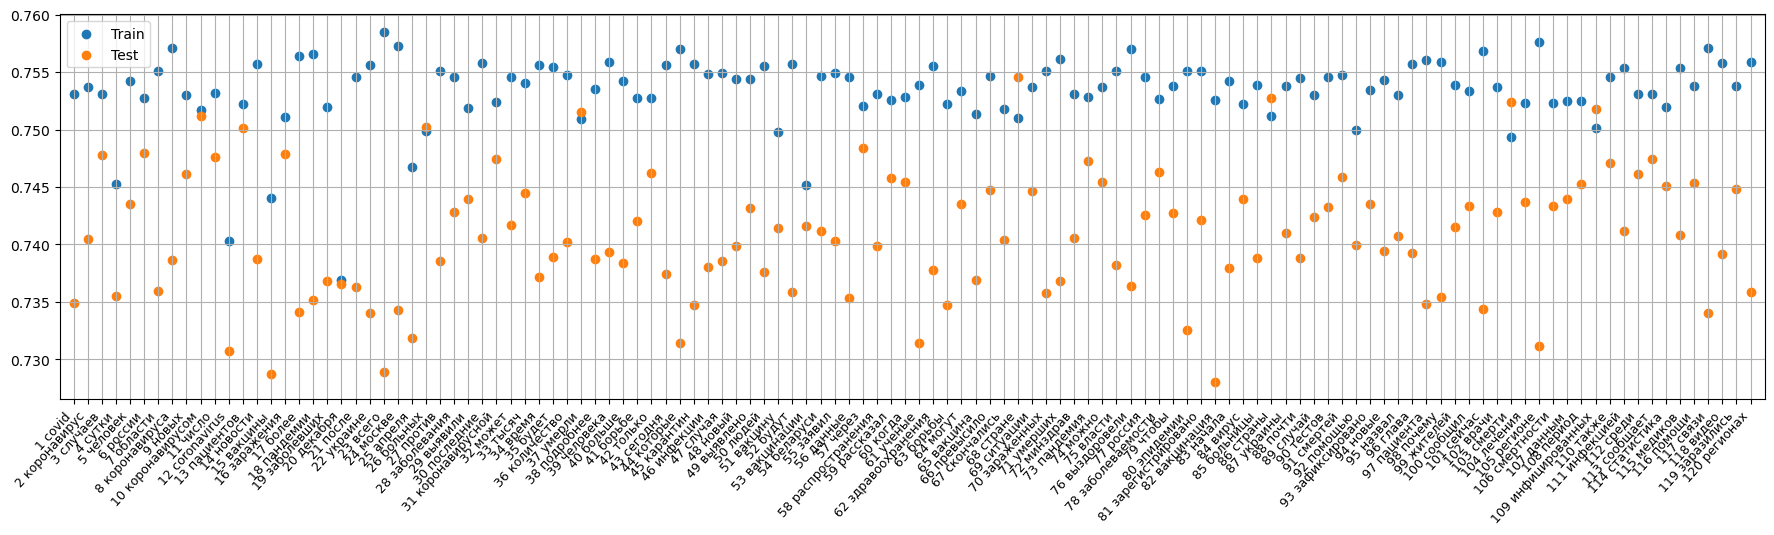

In [59]:
fig, ax = plt.subplots(1,1, figsize=(22,5))

ax.scatter(test_int, par_importance.train,  label="Train")
ax.scatter(test_int, par_importance.test, label="Test")
ax.legend()

ax.set_xticks(test_int)

trms_tmp = ["$i " * terms[i] for i in test_int]
ax.set_xticklabels(trms_tmp, rotation = 48, fontsize=9, ha="right");

ax.grid(which="both")

ax.set_xlim(0, maximum(test_int)+1)

# fig.savefig("../plots/ru-nn.png", bbox_inches = "tight", dpi=800)

In [60]:
cvals= log.(1 .+ df.favorite_count)
avals = 1 .+ df.retweet_count ; avals = log.(avals); avals = avals .- (minimum(avals) - 0.1) ; avals = avals ./ maximum(avals)
avals_t = [df.tind[i] == 1 ? plt.cm.Blues_r(avals[i]) : plt.cm.Reds_r(avals[i]) for i in eachindex(df.tind)];

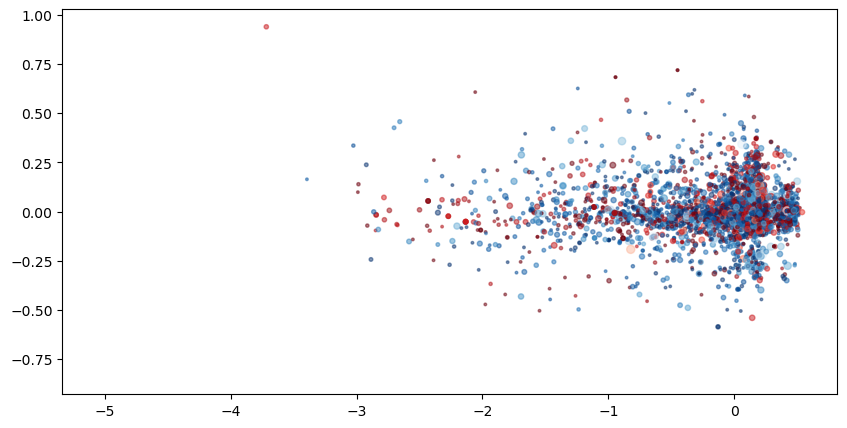

PyObject <matplotlib.collections.PathCollection object at 0x7fb62c3be700>

In [61]:
fig, ax= plt.subplots(1,1, figsize=(10,5))

ax.scatter(Yte[1,:], Yte[112,:], alpha=0.5, s=5.0.*cvals, c=avals_t, rasterized=true, label="April") # 3 / 4 

# ax.set_xlim(-0.4e-5, 0.8e-5)
# ax.set_ylim(-0.4e-5, 0.5e-5)

In [62]:
vars_nn = (test_int, par_importance.train, par_importance.test, terms[test_int])
# JLD2.@save "../data/tmp_files/ru-nn.jld" vars_nn

In [ ]:
new_terms = terms[sortperm(par_importance.test)][1:50]